***Linear Model - RBF Model - Polynomial Model***

In [66]:
import numpy as np
from sklearn.svm import SVR 
import matplotlib.pyplot as plt 
import pandas as pd 
from pandas_datareader.data import DataReader
%matplotlib inline

# ACCION = 'BBVA.MC'
# ACCION = '^GSPC'
ACCION = 'REP.MC'
FECHA_INICIO = '2022-09-01'
FECHA_FINAL  = '2022-09-30'

#  Cargamos el dataset usando la librería DataReader, fuente "yahoo".
dataframe = DataReader(ACCION, data_source='yahoo', start=FECHA_INICIO, end=FECHA_FINAL)
#  Añadimos las fechas al dataframe (esta en el indice, lo dejamos también)
dataframe["Date"] = dataframe.index
dataframe.head()

,High,Low,Open,Close,Volume,Adj Close,Date
Date,,,,,,,
2022-09-01,13.005,12.785,12.865,12.885,3803212,12.885,2022-09-01
2022-09-02,13.440,12.900,12.995,13.380,4960994,13.380,2022-09-02
2022-09-05,13.765,13.340,13.340,13.685,4975330,13.685,2022-09-05
2022-09-06,13.840,13.440,13.830,13.475,4309713,13.475,2022-09-06
2022-09-07,13.665,12.930,13.550,12.930,7808306,12.930,2022-09-07


  Formateamos los datos.-  cambio de orden, no veo cambios significativos salvo la fecha que la convierte a cadena de caracteres (str).

In [67]:
df = pd.DataFrame( {"open": dataframe['Open'],
                    "volume": dataframe['Volume'],
                    "high": dataframe['High'],
                    "low": dataframe['Low'],
                    "close": dataframe['Close'],
                    "date": dataframe['Date'].astype(str),
                    "adjclose": dataframe['Adj Close'], })
df.tail()

,open,volume,high,low,close,date,adjclose
Date,,,,,,,
2022-09-22,11.805,4370197,12.155,11.765,12.00,2022-09-22,12.00
2022-09-23,11.875,7004593,11.920,11.185,11.36,2022-09-23,11.36
2022-09-26,11.085,5753260,11.470,11.050,11.33,2022-09-26,11.33
2022-09-27,11.330,5206047,11.705,11.320,11.60,2022-09-27,11.60
2022-09-28,11.465,5625187,11.905,11.330,11.80,2022-09-28,11.80


  Creamos la función get_data que del dataframe de entrada nos devuelve dos listas:
    - el dataframe de fechas que hemos recogido solo el día, a numérico
    - y el dataframe de los precios de cierre

In [21]:
def get_data(df):  
    data = df.copy()
    data['date'] = data['date'].str.split('-').str[2]
    data['date'] = pd.to_numeric(data['date'])
    return [ data['date'].tolist(), data['close'].tolist() ]   # Convertimos la serie a una lista

In [68]:
dates, prices = get_data(df)
print("Fechas\n", dates, "\nPrecios\n", prices)
print("Tamaño: ", len(dates))

Fechas
 [1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 26, 27, 28] 
Precios
 [12.885000228881836, 13.380000114440918, 13.6850004196167, 13.475000381469727, 12.930000305175781, 12.824999809265137, 13.109999656677246, 13.149999618530273, 12.899999618530273, 12.850000381469727, 12.329999923706055, 11.960000038146973, 12.085000038146973, 11.949999809265137, 11.880000114440918, 12.0, 11.359999656677246, 11.329999923706055, 11.600000381469727, 11.800000190734863]
Tamaño:  20


In [74]:
def predict_prices(dates, prices, x, dibujar=False):
    dates = np.reshape(dates,(len(dates), 1))   # Convertimos una fila en una collumna (1 dimensión)
    x = np.reshape(x,(len(x), 1))
    
    svr_lin  = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    
    # Llenamos con los datos los modelos de regresión
    svr_lin .fit(dates, prices)
    svr_poly.fit(dates, prices)
    svr_rbf.fit(dates, prices)
    
    if dibujar:
        plt.scatter(dates, prices, c='k', label='Data')
        plt.plot(dates, svr_lin.predict(dates), c='g', label='Linear model')
        plt.plot(dates, svr_rbf.predict(dates), c='r', label='RBF model')    
        plt.plot(dates, svr_poly.predict(dates), c='b', label='Polynomial model')
    
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(ACCION + ' - Support Vector Regression')
        plt.legend()
        plt.show()
    
    return svr_rbf.predict(x), svr_lin.predict(x), svr_poly.predict(x)

  Mostramos el gráfico con las predicciones

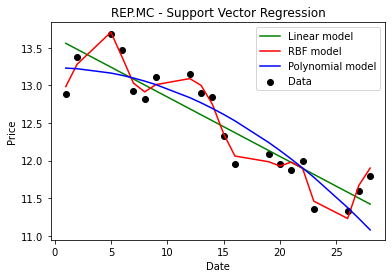

In [75]:
predicted_price = predict_prices(dates, prices, [29], True)

Mostramos los valores predichos para el rango de valores

In [77]:
print("** Predicción de precios de: ", ACCION, "  **")
tamaño = len(dates)
rango = [i for i in range(tamaño, tamaño + 5)]
precios = predict_prices(dates, prices, rango)
print(  "RBF model:        ", precios[0], 
        "\nLinear model:     ", precios[1],
        "\nPolynomial model: ", precios[2])

** Predicción de precios de:  REP.MC   **
RBF model:         [11.92730695 11.97985396 11.89940362 11.460069   10.95023452] 
Linear model:      [12.05440031 11.97520032 11.89600033 11.81680034 11.73760035] 
Polynomial model:  [12.13304745 12.02037441 11.90220512 11.77853959 11.64937781]


  Vamos a calcular el % de subida, del primer dato al 5 => fuerza?

In [78]:
print("** Predicción Variación de precio en 5 días: ", ACCION, "  **")
for p in precios:
    cambio = (p[4] - p[0]) / p[0]
    print(f"Variación: {cambio:.2} %")

** Predicción Variación de precio en 5 días:  REP.MC   **
Variación: -0.082 %
Variación: -0.026 %
Variación: -0.04 %
